### BBC News Article Text Classification

Use Matrix Factorization to Classify BBC News Articles

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [184]:
# Load Datasets
train = pd.read_csv('BBC_News_Train.csv')
test = pd.read_csv('BBC_News_Test.csv')
train['categoryId'] = train['Category'].factorize()[0]

print(f"Train, Test length is {len(train), len(test)}")
train.head()

Train, Test length is (1490, 735)


,ArticleId,Text,Category,categoryId
0,1833,worldcom ex-boss launches defence lawyers defe...,business,0
1,154,german business confidence slides german busin...,business,0
2,1101,bbc poll indicates economic gloom citizens in ...,business,0
3,1976,lifestyle governs mobile choice faster bett...,tech,1
4,917,enron bosses in $168m payout eighteen former e...,business,0


### Part I: Exploratory Data Analysis

Notes and Observations:
* All text has already been converted to lower case
* Train and Test sets have balanced article length
* Categories are balanced differently in Test compared to Train Sets
* Test dataset does not have category labels. The Kaggle portal will tell you your accuracy once you submit an answer


In [164]:
train.iloc[0]['Text']

'worldcom ex-boss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness.  cynthia cooper  worldcom s ex-head of internal accounting  alerted directors to irregular accounting practices at the us telecoms giant in 2002. her warnings led to the collapse of the firm following the discovery of an $11bn (£5.7bn) accounting fraud. mr ebbers has pleaded not guilty to charges of fraud and conspiracy.  prosecution lawyers have argued that mr ebbers orchestrated a series of accounting tricks at worldcom  ordering employees to hide expenses and inflate revenues to meet wall street earnings estimates. but ms cooper  who now runs her own consulting business  told a jury in new york on wednesday that external auditors arthur andersen had approved worldcom s accounting in early 2001 and 2002. she said andersen had given a  green light  to the procedures and practices used by worldcom. mr ebb

Median text length in train set is 1961.0 words
Median text length in test set is 1979.0 words


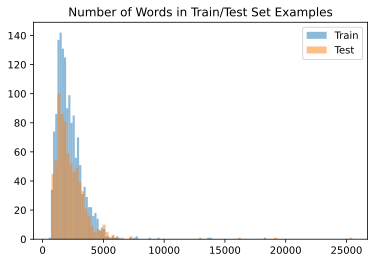

In [165]:
train['number_of_words'] = train['Text'].apply(lambda x: len(x))
test['number_of_words'] = test['Text'].apply(lambda x: len(x))

print(f"Median text length in train set is {np.median(train['number_of_words'])} words")
print(f"Median text length in test set is {np.median(test['number_of_words'])} words")

plt.hist(train['number_of_words'], bins=100, alpha=0.5)
plt.hist(test['number_of_words'], bins=100, alpha=0.5)
plt.title('Number of Words in Train/Test Set Examples')
plt.legend(['Train', 'Test'])
plt.show()

In [185]:
train.Category.value_counts()

sport            346
business         336
politics         274
entertainment    273
tech             261
Name: Category, dtype: int64

### Part II: Model Building / Training / Results

#### Data Preparation

In [363]:
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer

# Voctorizer converts text into sparse matrix
tfidf_vectorizer = TfidfVectorizer(max_df = 0.95, min_df = 5, max_features = 2000, stop_words='english')

X_train = tfidf_vectorizer.fit_transform(train['Text'])
X_test = tfidf_vectorizer.fit_transform(test['Text'])

#### Fit Model

In [364]:
# text and category are now the equivalent of the conventional X and y datasets
nmf = NMF(5, random_state=8, alpha=.15, l1_ratio=.5, init='nndsvd').fit(X_train)
nmf_features_train = nmf.transform(X_train)

/Users/Wee-YO/miniconda3/envs/py39/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1477: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/Users/Wee-YO/miniconda3/envs/py39/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1477: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(


#### Measure Accuracy of Train Set Predictions

Because the train set labels don't necessarily match the prediction labels, we'll need to iterate to get them to match. This bit of code tests each permutation of the numeric category labels mapped to the Train Set labels.

In [365]:
from itertools import permutations
best_acc = 0
best_order = [0, 1, 2, 3, 4]

for c in permutations([0, 1, 2, 3, 4]):
    pred_class = pd.DataFrame({'id' : c, 'category' : ['politics', 'sport', 'tech', 'entertainment', 'business']})
    train_pred = pd.DataFrame({'id' : pd.DataFrame(nmf_features_train).idxmax(axis=1)})
    train['Pred'] = train_pred.merge(pred_class, how = 'left', on = 'id').category
    if (train['Pred'] == train['Category']).mean() > best_acc:
        best_acc = (train['Pred'] == train['Category']).mean()
        best_order = c
        
print(best_order, best_acc)

(1, 0, 2, 3, 4) 0.8718120805369127


#### Generate Test Set Predictions

In [366]:
nmf_features_test = nmf.transform(X_test)
pred_class = pd.DataFrame({'id' : best_order, 'category' : ['politics', 'sport', 'tech', 'entertainment', 'business']})
test_pred = pd.DataFrame({'id' : pd.DataFrame(nmf_features_test).idxmax(axis=1)})
test['Pred'] = test_pred.merge(pred_class, how = 'left', on = 'id').category
test.head()

/Users/Wee-YO/miniconda3/envs/py39/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1477: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(


,ArticleId,Text,Pred
0,1018,qpr keeper day heads for preston queens park r...,politics
1,1319,software watching while you work software that...,business
2,1138,d arcy injury adds to ireland woe gordon d arc...,sport
3,459,india s reliance family feud heats up the ongo...,business
4,1020,boro suffer morrison injury blow middlesbrough...,sport


### Compare to Supervised Learning Methods

We'll try a few supervised sklearn methods to see how they compare with the Unsupervised predictions
* Support Vector Machines
* Naive Bayes
* Decision Tree
* Random Forest

In [292]:
# Supervised Learning Methods
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [367]:
X_train = train['Text']
X_test = test['Text']
y_train = train['Category']
y_test = test['Pred']

In [368]:
svm = Pipeline([('tfidf', TfidfVectorizer()),
               ('clf', LinearSVC())])

svm.fit(X_train,y_train)
test_predict = svm.predict(X_test)

print(f"SVM Train Accuracy Score is {round(svm.score(X_train,y_train)*100)}%")
print(f"SVM Test Prediction Accuracy Score is {round(accuracy_score(test_predict, y_test)*100)}%")

SVM Train Accuracy Score is 100%
SVM Test Prediction Accuracy Score is 43%


In [319]:
nb = Pipeline([('tfidf', TfidfVectorizer()),
               ('clf', MultinomialNB()),
              ])

nb.fit(X_train,y_train)
test_predict = nb.predict(X_test)

print(f"Naive Bayes Train Accuracy Score is {round(dt.score(X_train,y_train)*100)}%")
print(f"Naive Bayes Test Prediction Accuracy Score is {round(accuracy_score(test_predict, y_test)*100)}%")

Naive Bayes Train Accuracy Score is 100%
Naive Bayes Test Prediction Accuracy Score is 44%


In [369]:
dt = Pipeline([('tfidf', TfidfVectorizer()),
                ('dt', DecisionTreeClassifier())])

dt.fit(X_train, y_train)
test_predict = dt.predict(X_test)

print(f"Decision Tree Train Accuracy Score is {round(dt.score(X_train,y_train)*100)}%")
print(f"Decision Tree Test Prediction Accuracy Score is {round(accuracy_score(test_predict, y_test)*100)}%")

Decision Tree Train Accuracy Score is 100%
Decision Tree Test Prediction Accuracy Score is 38%


In [370]:
rfc = Pipeline([('tfidf', TfidfVectorizer()),
                ('rfc', RandomForestClassifier(n_estimators=100))])

rfc.fit(X_train, y_train)
test_predict = rfc.predict(X_test)

print(f"Random Forest Train Accuracy Score is {round(dt.score(X_train,y_train)*100)}%")
print(f"Random Forest Test Prediction Accuracy Score is {round(accuracy_score(test_predict, y_test)*100)}%")

Random Forest Train Accuracy Score is 100%
Random Forest Test Prediction Accuracy Score is 45%


#### Confusion Matrix of NMF Predictions Compared to Random Forest

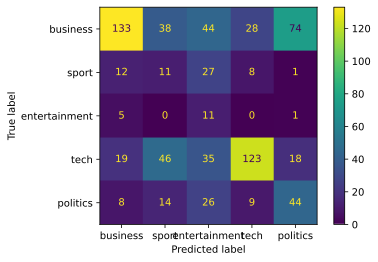

In [322]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
pred_class = pd.DataFrame({'id' : best_order, 'category' : ['politics', 'sport', 'tech', 'entertainment', 'business']})
cm = confusion_matrix(y_test, test_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pred_class.sort_values('id')['category'].to_list())
disp.plot()
plt.show()

In [328]:
# Create csv for submission to kaggle competition home page
test[['ArticleId', 'Pred']].rename({'Pred':'Category'}, axis=1).to_csv('wjr_submission.csv', index=False)

In [377]:
pd.concat([test['ArticleId'], pd.Series(test_predict)], axis=1).rename({0:'Category'}, axis=1).to_csv('wjr_submission_sup.csv', index=False)

### Conclusions

I was able to train a classifer using the unsupervised NMF method and generate predictions for the test set. I did the same for several supervised methods. After playing around with the hyperparameters on the NMF method I trained a classifier that gave me about 43% accuracy on the test set, after submitting to the Kaggle project. It's possible that with some better optimization of the hyperparemeters and some different choices I could do a little better on this. As you can see in the confusion matrix directly above, using the Random Forest predictions as a 'ground truth', it seems like business and tech articels were relatively easy for the model to correctly classify, but for the other three categories it was kind of hopeless.

In contrast, the supervised methods proved to be much more effective. I easily got 95%+ accuracy with the supervised methods (Random Forest, SVM, Naive Bayes) without really even tuning any of the hyperparameters. 